In [1]:
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using ForneyLab
using NARMAX
import ProgressMeter
using CSV
using DataFrames
using Statistics

In [2]:
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, Gamma

In [3]:
include("../src/polynomial.jl")
include("../src/data.jl");

## Load generated signal

In [56]:
# Load from .mat file
mat_data = matread("../datasets/verification/realizations/NARMAXsignal_stde0.05_degree3_delays4_D22_r99.mat")

train_size = 200
test_size = 1000

# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:train_size) .+ transient

# Length of testing signal
ix_tst = collect(1:test_size) .+ transient;

# Extract data sets
input_trn = mat_data["uTrain"][ix_trn]
noise_trn = mat_data["eTrain"][ix_trn]
output_trn = mat_data["yTrain"][ix_trn]
T_trn = length(input_trn)

input_tst = mat_data["uTest"][ix_tst]
noise_tst = mat_data["eTest"][ix_tst]
output_tst = mat_data["yTest"][ix_tst]
T_tst = length(input_tst)

# System parameters
η_true = mat_data["system"]["theta"][:]
τ_true = inv(mat_data["options"]["stde"]^2);

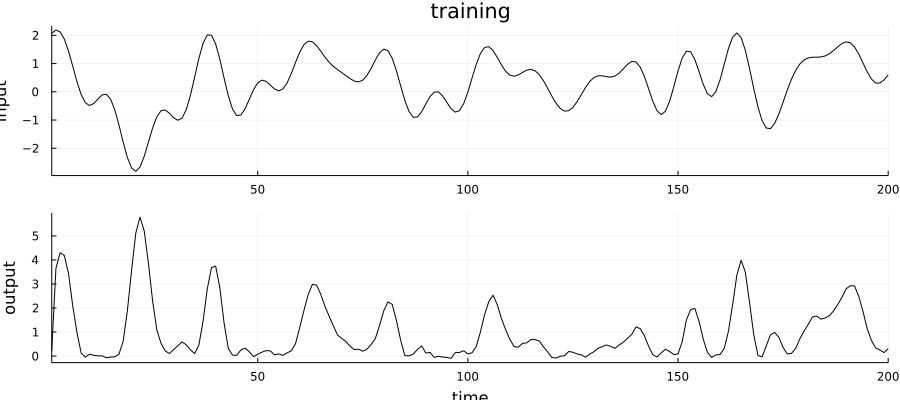

In [57]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1), xlims=(1, train_size))

In [58]:
function model_specification(ϕ; M1=M1, M2=M2, M3=M3, N=N)

    graph = FactorGraph()

    # Observed variables
    @RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
    @RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
    @RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
    @RV u_k; placeholder(u_k, :u_k)

    # Time-invariant parameters
    @RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
    @RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N,N)))

    # Likelihood
    @RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
    placeholder(y_k, :y_k)

    q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
    algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
    return algorithmSourceCode(algorithm, free_energy=true)
    
end

model_specification (generic function with 1 method)

In [59]:
function experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ, priors; M1=1, M2=1, M3=1, N=3, num_iters=5, computeFE=false)

    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    "Inference execution"

    # Extract prior parameters
    θ_k = priors["θ"]
    τ_k = priors["τ"]

    # Initialize marginals
    marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                     :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

    # Preallocate free energy array
    Fq = zeros(T_trn-maxM, num_iters)

    # Preallocate parameter arrays
    params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
    params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

    # Preallocate prediction arrays
    predictions = (zeros(T_trn,), zeros(T_trn,))
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)
        
        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

        # Compute prediction error
        errors[k] = output_trn[k] - predictions[1][k]
        
        # Set data 
        data = Dict(:y_k => output_trn[k],
                    :u_k => input_trn[k],
                    :u_kmin1 => u_kmin1,
                    :y_kmin1 => y_kmin1,
                    :e_kmin1 => e_kmin1,
                    :m_θ => θ_k[1],
                    :w_θ => θ_k[2],
                    :a_τ => τ_k[1],
                    :b_τ => τ_k[2])
        
        # Iterate updates
        for n = 1:num_iters
            
            # Compute free energy
            if computeFE
                Fq[ii,n] = freeEnergy(data,marginals)
            end
            
            # Update parameters
            stepθ!(data, marginals)
            stepτ!(data, marginals)
            
        end 
        
        # Update params
        θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
        τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
        
        # Store params
        params_θ[1][ii,:] = θ_k[1]
        params_θ[2][ii,:,:] = θ_k[2]
        params_τ[1][ii] = τ_k[1]
        params_τ[2][ii] = τ_k[2]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = (zeros(T_tst,), zeros(T_tst,))
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

        # Update error
        errors[k] = output_tst[k] - predictions[1][k]
        
    end

    "Simulation"

    # Prepare array
    simulations = (zeros(T_tst,), zeros(T_tst,))

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[1][k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[1][k] = θ_k[1]'*ϕx
        
        simulations[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[1][maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

    if computeFE
        return RMS_sim, RMS_prd, Fq
    else
        return RMS_sim, RMS_prd, simulations, predictions, θ_k
    end
end

experiment_FEM (generic function with 1 method)

In [60]:
function experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ; M1=1, M2=1, M3=1, N=1, λ=1.00)
    
    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    # Parameters
    P = λ.*Matrix{Float64}(I,N,N)
    w_k = zeros(N,)

    # Preallocate prediction array
    predictions = zeros(T_trn,)
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)

        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        # Update data vector
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        
        # Update weights
        α = output_trn[k] - w_k'*ϕx 
        g = P*ϕx*inv(λ + ϕx'*P*ϕx)
        P = inv(λ)*P - g*ϕx'*inv(λ)*P
        w_k = w_k + α*g
        
        # Prediction
        predictions[k] = w_k'*ϕx
        errors[k] = output_trn[k] - predictions[k]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = zeros(T_tst,)
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[k] = w_k'*ϕx

        # Update error
        errors[k] = output_tst[k] - predictions[k]
        
    end

    "Simulation"

    # Prepare array
    simulations = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[k] = w_k'*ϕx
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[maxM+1:end] - output_tst[maxM+1:end]).^2))

    return RMS_sim, RMS_prd, simulations, predictions, w_k
end

experiment_RLS (generic function with 1 method)

In [61]:
# find order
M1, M2, M3 = 1, 1, 1
poly_order = 3
options = Dict("na"=>M1, "nb"=>M2, "ne"=>M3, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)

PΦ = gen_combs(options)
ϕ_fl(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)]
N = size(PΦ,2)

22

In [63]:
# Specify model and compile update functions
source_code = model_specification(ϕ_fl, M1=M1, M2=M2, M3=M3, N=N)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [64]:
println(source_code)

begin

function stepτ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_τ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_τ]))
messages[2] = ruleVariationalNARMAXIn6PPPPPPN(ϕ_fl, ProbabilityDistribution(Univariate, PointMass, m=data[:y_k]), marginals[:θ], ProbabilityDistribution(Univariate, PointMass, m=data[:u_k]), ProbabilityDistribution(Multivariate, PointMass, m=data[:u_kmin1]), ProbabilityDistribution(Multivariate, PointMass, m=data[:y_kmin1]), ProbabilityDistribution(Multivariate, PointMass, m=data[:e_kmin1]), nothing)

marginals[:τ] = messages[1].dist * messages[2].dist

return marginals

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistributio

In [50]:
# Initialize priors
priors = Dict("θ" => (zeros(N,), Matrix{Float64}(I,N,N)), 
              "τ" => (1.0, 1.0))
prior_mτ = priors["τ"][1] ./ priors["τ"][2]  

1.0

In [65]:
rms_sim, rms_pred, sim, pred, coefs = experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ_fl, priors, M1=M1, M2=M2, M3=M3, N=N, num_iters=20, computeFE=false)

(0.05637086434813867, 0.05581098483762709, ([0.0, 0.04241120836300165, 0.06623572914331774, -0.029917423902544257, -0.024964900248987024, 0.00655857721599324, 0.07141722060576434, 0.3712869547713147, 1.0685004118415977, 1.9766783449625542  …  -0.0008779270303798904, 0.11631079329513772, 0.27657226320545925, 0.40787239312537354, 0.41237689365709584, 0.2589682756794748, 0.08455677378726123, 0.175446060698372, 0.7787478314612082, 1.8907135808514568], [0.0, 0.11215357157968692, 0.11829383490551396, 0.11073677769893119, 0.1096172213914866, 0.11226530569634903, 0.11688145226520937, 0.12124227365444358, 0.12356147715501303, 0.11999038359627806  …  0.11311782296487273, 0.11508880551271011, 0.11711208198250078, 0.11860346641370359, 0.11851895412638744, 0.11980329677220505, 0.12458811052872601, 0.12273108663594216, 0.13534633773763616, 0.14059887959711106]), ([0.0, 0.04241120836300165, 0.07384242654992895, -0.024598407670653823, -0.017905542244983665, -0.005102454366546181, 0.06989724116404404, 

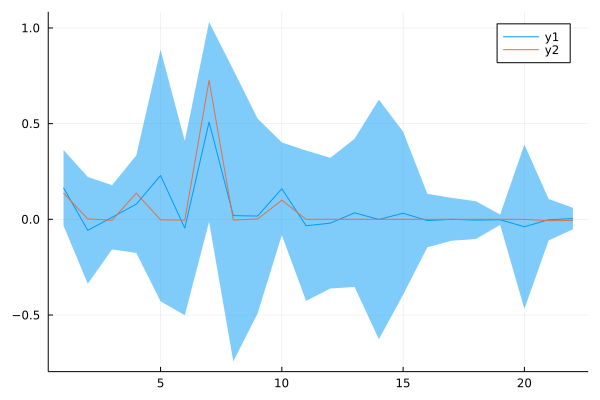

In [66]:
plot(coefs[1], ribbon=sqrt.(diag(inv(coefs[2]))))
plot!(η_true)


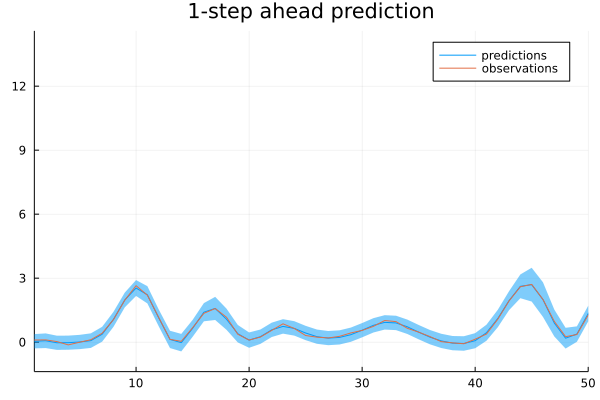

In [68]:
plot(sim[1][2:end], ribbon=sqrt.(sim[2][2:end]), label="predictions")
plot!(output_tst[1:end], xlims=(1, 50), title="1-step ahead prediction", label="observations")

In [72]:
rms_sim, rms_pred, sim, pred, coefs = experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ_fl, M1=M1, M2=M2, M3=M3, N=N, λ=1.0)

(0.0654071692804174, 0.06521109494219311, [0.0, 0.04240282747627637, 0.06133134041348782, -0.02679456208804553, -0.023710673040239064, 0.003285326080555418, 0.07313779835723819, 0.38521241427347125, 1.0875543059437565, 1.9863150715577764  …  0.00909313182640574, 0.12461262796585684, 0.27814041093618747, 0.39979350140875136, 0.39715315103765814, 0.24307699800098312, 0.07659381146421748, 0.1844523856247109, 0.8047148145333196, 1.9206432118028138], [0.0, 0.04240282747627637, 0.06983505474605675, -0.020065284649445403, -0.015765903886441703, -0.01110808685517006, 0.07187076549676609, 0.3887219963433806, 1.0902770054678275, 1.9834838540049944  …  0.022588074516111684, 0.12121670612000632, 0.28289010073631077, 0.40470812673289813, 0.37867511832206524, 0.25533074869172084, 0.08490138261907873, 0.1879340962751441, 0.8054159090165368, 1.9170220266236222], [0.15709673559238244, -0.02845309138364039, 0.0007031264654435537, 0.07769679400300254, 0.245189093177798, -0.025300772444340015, 0.447095713

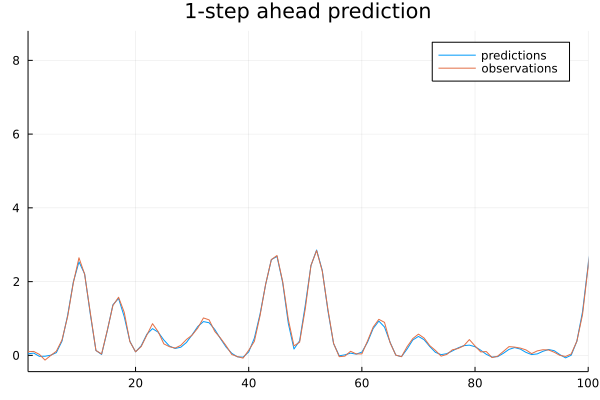

In [73]:
plot(sim[2:end], label="predictions")
plot!(output_tst, xlims=(1, 100), title="1-step ahead prediction", label="observations")